In [1]:
import numpy as np, pandas as pd

%load_ext autoreload
%autoreload 2

label_dict = {
    0: 'T-shirt/top',
    1: 'Trouser',
    2: 'Pullover',
    3: 'Dress',
    4: 'Coat',
    5: 'Sandal',
    6: 'Shirt',
    7: 'Sneaker',
    8: 'Bag',
    9: 'Ankle boot'
}

tr = pd.read_parquet('train.parquet')#.sample(20000, random_state=911).reset_index(drop=True)
tst = pd.read_parquet('test.parquet')#.sample(5000, random_state=911).reset_index(drop=True)
tr.label = tr.label.map(label_dict).astype('category')
tst.label = tst.label.map(label_dict).astype('category')

tr.info()
tr.head(3)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60000 entries, 0 to 59999
Columns: 785 entries, label to pixel784
dtypes: category(1), int64(784)
memory usage: 358.9 MB


,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,Pullover,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Ankle boot,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,Shirt,0,0,0,0,0,0,0,5,0,...,0,0,0,30,43,0,0,0,0,0


Посмотрим на данные

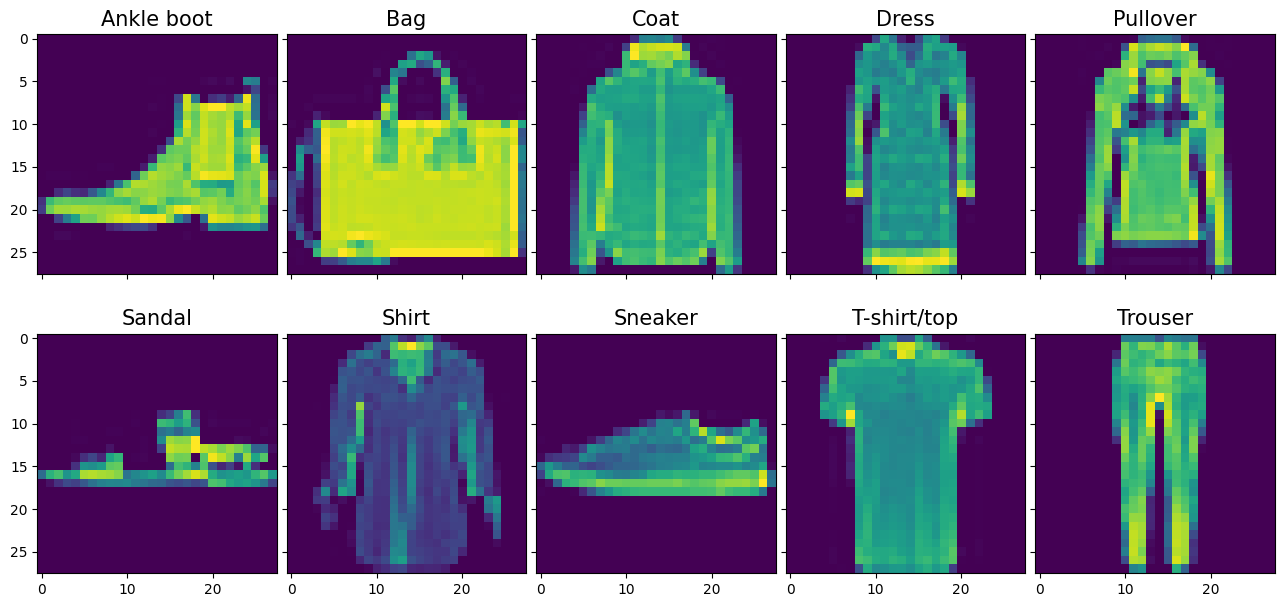

In [2]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid

def plot_img(X, idx, ax=None):
    if ax is None:
        fig, ax = plt.subplots(figsize=(5, 5))

    ax.set_title(X.loc[idx, 'label'], fontsize=15)
    ax.imshow(X.iloc[idx, 1:].values.astype(np.int32).reshape(28, 28))

fig = plt.figure(figsize=(20., 7))
grid = ImageGrid(fig, 111, nrows_ncols=(2, 5), axes_pad=(0.1, 0.6))

class_examples = tr.groupby('label', observed=True).sample(1, random_state=911)
images, labels = class_examples.iloc[:, 1:].values.astype(np.int32), class_examples.label

for i, (ax, im) in enumerate(zip(grid, images)):
    ax.set_title(labels.iloc[i], fontsize=15)
    ax.imshow(im.reshape(28, 28))

In [3]:
X_tr, y_tr, X_val, y_val = tr.iloc[:, 1:].values.astype(np.int64), tr.label.cat.codes.values, \
                            tst.iloc[:, 1:].values.astype(np.int64), tst.label.cat.codes.values

print('tr shape:', X_tr.shape, 'val shape:', X_val.shape)

tr shape: (60000, 784) val shape: (10000, 784)


## Часть ^:. Памятка чайника на тему поиска соседей

**Постановка задачи:**
- дана обучающая выборка X_tr, тестовая X_val, число k, метрика M
- для каждого объекта из X_val (будем называть один такой объект символом q) нужно найти k ближайших соседей по метрике (функции близости) М из X_tr

**Характеристики алгоритмов поиска ближайших соседей:**
1) поддерживаемые функции близости
    - brute: любые
2) время построения индекса
    - индекс - специальная структура данных (обычно - надстройка над X_tr) для [быстрого] поиска соседей в ней
    - brute: индекс = X_tr
3) необходимая оперативная память для поддержания индекса
    - brute: data
4) время поиска k ближайших соседей для q
    - brute: X_tr x X_val подсчетов метрики M + выбор k минимальных для каждого q
5) точность найденных соседей
    - на самом деле полнота, а не точность :)
    - `recall@k(q) = |set_intersect(predicted_nn_idx(q), true_nn_idx(q))| / k` для одного q
        - predicted_nn_idx(q) ~ предсказанные алгоритмом индексы k ближ. соседей
        - true_nn_idx(q) ~ истинные индексы k ближ. соседей = те, что предсказал brute-алгоритм
    - Для X_val считаем средний recall@k по всем q
    - brute: `recall@k = 1`

## Часть 0. Брут (0_0)

- индекс:
    вся выборка
- поиск соседей:
    - посчитать попарные расстояния X_tr x X_val
    - найти соседей как аргмин расстояний

In [4]:
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import balanced_accuracy_score
from utils import Timer

k = 11
knn = NearestNeighbors(n_neighbors=k, algorithm='brute', metric='euclidean')

timer = Timer()
knn.fit(X_tr, y_tr)
timer.tick('BRUTE | fit_time', reset=True)

predicted_nn_idx = knn.kneighbors(X_val, return_distance=False)
timer.tick('BRUTE | search_time', reset=True)

from utils import knn_predict_classification
y_pred = knn_predict_classification(predicted_nn_idx, y_tr, n_classes=10)
timer.tick('func: knn_predict_classification')

print('balanced accuracy of brute:', round(balanced_accuracy_score(y_val, y_pred), 3))

BRUTE | fit_time: 0.114 sec
BRUTE | search_time: 17.565 sec
func: knn_predict_classification: 0.003 sec
balanced accuracy of brute: 0.855


Проблемы:
1) размеры матрицы расстояний = (tr.shape, val.shape)
   - лечение: batched knn (вшито в sklearn)
2) скорость вычисления попарных расстояний
3) хранение всей выборки

Плюсы:
1) найденные соседи реально ближайшие (без шуток)
2) любые функции близости
3) индекс строится за 0 сек!

## Часть 1. KDTree  \_\_)+_+)__/

In [6]:
from sklearn.neighbors import KDTree

KDTree.valid_metrics

['euclidean',
 'l2',
 'minkowski',
 'p',
 'manhattan',
 'cityblock',
 'l1',
 'chebyshev',
 'infinity']

In [7]:
knn = NearestNeighbors(n_neighbors=k, algorithm='kd_tree', metric='euclidean')
timer.reset()

knn.fit(X_tr, y_tr)
timer.tick('KDTree | fit_time', reset=True)

predicted_nn_idx = knn.kneighbors(X_val, return_distance=False)
timer.tick('KDTree | search_time')

from utils import knn_predict_classification
y_pred = knn_predict_classification(predicted_nn_idx, y_tr, n_classes=10)

print('balanced accuracy of kd_tree:', round(balanced_accuracy_score(y_val, y_pred), 3))

KDTree | fit_time: 19.365 sec
KDTree | search_time: 632.456 sec
balanced accuracy of kd_tree: 0.855


Проблемы:
1) ненулевое время построения индекса :)
2) скорость поиска
3) хранение всей выборки + хранение дерева
4) ограниченные функции близости
   
Плюсы:

(/^/__/^/)

## Часть 2. AnnPlotter (^(*)-(\*)^)

In [8]:
from utils import AnnPlotter

plotter = AnnPlotter(X_tr, y_tr, k=11, metric='euclidean', n_classes=10)
plotter.calc_true_nn(X_val, y_val)

Brute | search_time: 20.99 sec


In [9]:
%time plotter.prepare_sklearn(X_val, y_val, name='KDTree', leaf_sizes=[30, 100, 500, 1000], algorithm='kd_tree', metric='euclidean')


KDTree.leaf_size=30 | build_time: 19.435 sec
KDTree.leaf_size=30 | search_time: 637.034 sec

KDTree.leaf_size=100 | build_time: 17.637 sec
KDTree.leaf_size=100 | search_time: 582.084 sec

KDTree.leaf_size=500 | build_time: 12.458 sec
KDTree.leaf_size=500 | search_time: 532.198 sec

KDTree.leaf_size=1000 | build_time: 10.581 sec
KDTree.leaf_size=1000 | search_time: 525.222 sec
CPU times: total: 38min 44s
Wall time: 38min 57s


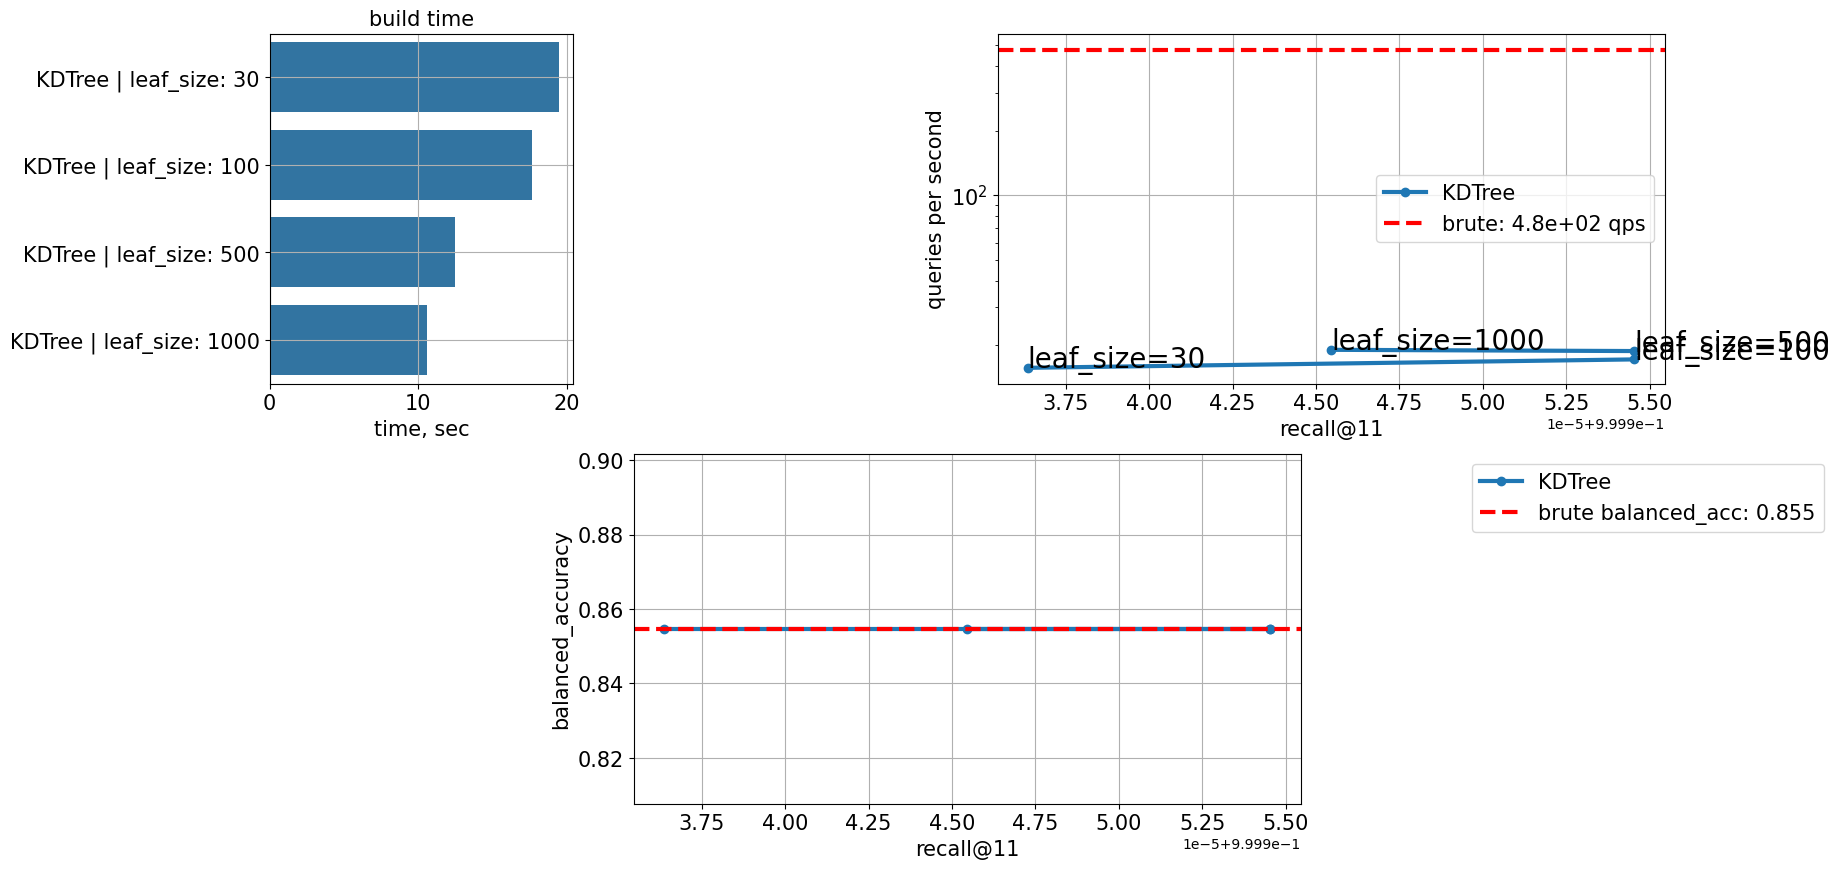

In [10]:
plotter.show()

## Часть 3. LSH (\\_(l_l)_/). Locally-Sensitive Hashing

[**FALCONN**](https://github.com/FALCONN-LIB/FALCONN) - LSH Families for cosine similarity* (библиотека мертва)

Реализовано [тут](https://github.com/facebookresearch/faiss/wiki/Faiss-indexes)
  
  2015 - Practical and Optimal LSH for Angular Distance https://arxiv.org/abs/1509.02897
  
  Туториал по `LSH` и его реализации в библиотеке (оно же, коротко и ясно):
  
  https://github.com/FALCONN-LIB/FALCONN/wiki/LSH-Primer <br>
  https://github.com/FALCONN-LIB/FALCONN/wiki/LSH-Families
  
  
[**datasketch**](https://github.com/ekzhu/datasketch) - LSH Family for Jaccard similarity

In [11]:
%time plotter.prepare_lsh(X_val, y_val, name='LSH', nbits=[10, 50, 200, 784, 784 * 2, 784 * 4, 784 * 8])


LSH. nbit=10 | build_time: 0.233 sec
LSH. nbit=10 | search_time: 0.587 sec

LSH. nbit=50 | build_time: 0.253 sec
LSH. nbit=50 | search_time: 0.991 sec

LSH. nbit=200 | build_time: 0.374 sec
LSH. nbit=200 | search_time: 0.884 sec

LSH. nbit=784 | build_time: 0.906 sec
LSH. nbit=784 | search_time: 2.177 sec

LSH. nbit=1568 | build_time: 1.545 sec
LSH. nbit=1568 | search_time: 4.08 sec

LSH. nbit=3136 | build_time: 2.893 sec
LSH. nbit=3136 | search_time: 7.936 sec

LSH. nbit=6272 | build_time: 5.625 sec
LSH. nbit=6272 | search_time: 16.817 sec
CPU times: total: 3min 12s
Wall time: 55.6 s


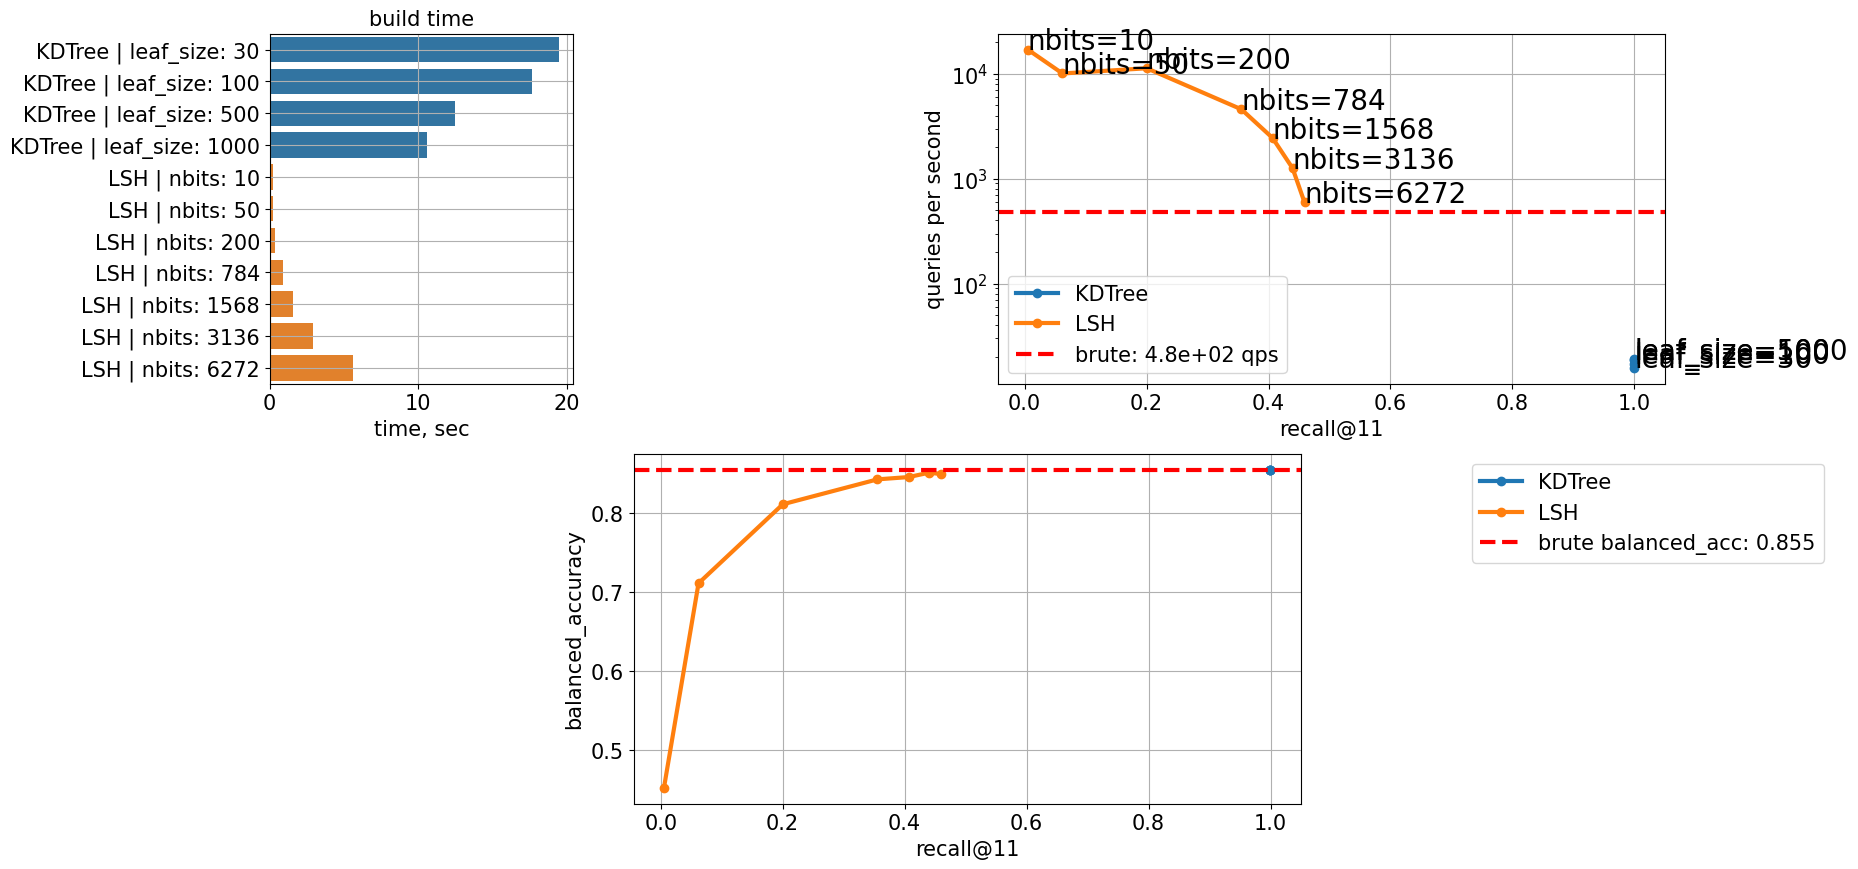

In [12]:
plotter.show()

Проблемы:
1) при скоростях существенно бОльших brute_qps качество плохое
2) в теории: хранение всей выборки + L таблиц + KL хэш-функций
3) на практике для faiss.LSH: храним для каждого вектора только его ближайший базисный вектор = nbits
4) без multiprobe плохое качество для небольших nbits
5) на практике для faiss.LSH: функция близости = Hamming на базисных векторах-кодировках

Плюсы:
1) быстрое построение индекса
2) в теории: любые функции близости, главное подобрать locally-sensitive хэш-функции

## Часть 4. HNSW _/`-\_-7. Hierarchical Navigable Small World
  
[**nmslib**](https://github.com/nmslib/nmslib/) (не ставится на винду)<br>
[**hnswlib**](https://github.com/nmslib/hnswlib)<br>
[**faiss**](https://github.com/facebookresearch/faiss/wiki/Faiss-indexes)
  
**Navigable Small World** <br>
  2013 - Approximate nearest neighbor algorithm based on navigable
small world graphs https://publications.hse.ru/pubs/share/folder/x5p6h7thif/128296059.pdf


**Hierarchical Navigable Small World** <br>
  2016 - Efficient and robust approximate nearest neighbor search using Hierarchical Navigable Small World graphs https://arxiv.org/abs/1603.09320

Сравнения между собой при разных гиперпараметрах

In [13]:
hnsw_plotter = AnnPlotter(X_tr, y_tr, k=11, metric='euclidean', n_classes=10)
hnsw_plotter.calc_true_nn(X_val, y_val)

Brute | search_time: 21.351 sec


In [14]:
ef_search_list = [2, 50, 500]
hnsw_plotter.prepare_hnsw(X_val, y_val, name='efC=500. M=5', ef_construction=500, M=5, ef_search_list=ef_search_list)
hnsw_plotter.prepare_hnsw(X_val, y_val, name='efC=10. M=5', ef_construction=10, M=5, ef_search_list=ef_search_list)
hnsw_plotter.prepare_hnsw(X_val, y_val, name='efC=500. M=200', ef_construction=500, M=200, ef_search_list=ef_search_list)
hnsw_plotter.prepare_hnsw(X_val, y_val, name='efC=10. M=200', ef_construction=10, M=200, ef_search_list=ef_search_list)


efC=500. M=5. ef_construction=500, M=5 | build_time: 16.377 sec
efC=500. M=5. ef_search=2 | search_time: 0.18 sec
efC=500. M=5. ef_search=50 | search_time: 0.428 sec
efC=500. M=5. ef_search=500 | search_time: 2.329 sec

efC=10. M=5. ef_construction=10, M=5 | build_time: 0.934 sec
efC=10. M=5. ef_search=2 | search_time: 0.15 sec
efC=10. M=5. ef_search=50 | search_time: 0.339 sec
efC=10. M=5. ef_search=500 | search_time: 1.931 sec

efC=500. M=200. ef_construction=500, M=200 | build_time: 27.502 sec
efC=500. M=200. ef_search=2 | search_time: 0.484 sec
efC=500. M=200. ef_search=50 | search_time: 1.101 sec
efC=500. M=200. ef_search=500 | search_time: 4.957 sec

efC=10. M=200. ef_construction=10, M=200 | build_time: 13.504 sec
efC=10. M=200. ef_search=2 | search_time: 0.441 sec
efC=10. M=200. ef_search=50 | search_time: 1.058 sec
efC=10. M=200. ef_search=500 | search_time: 4.483 sec


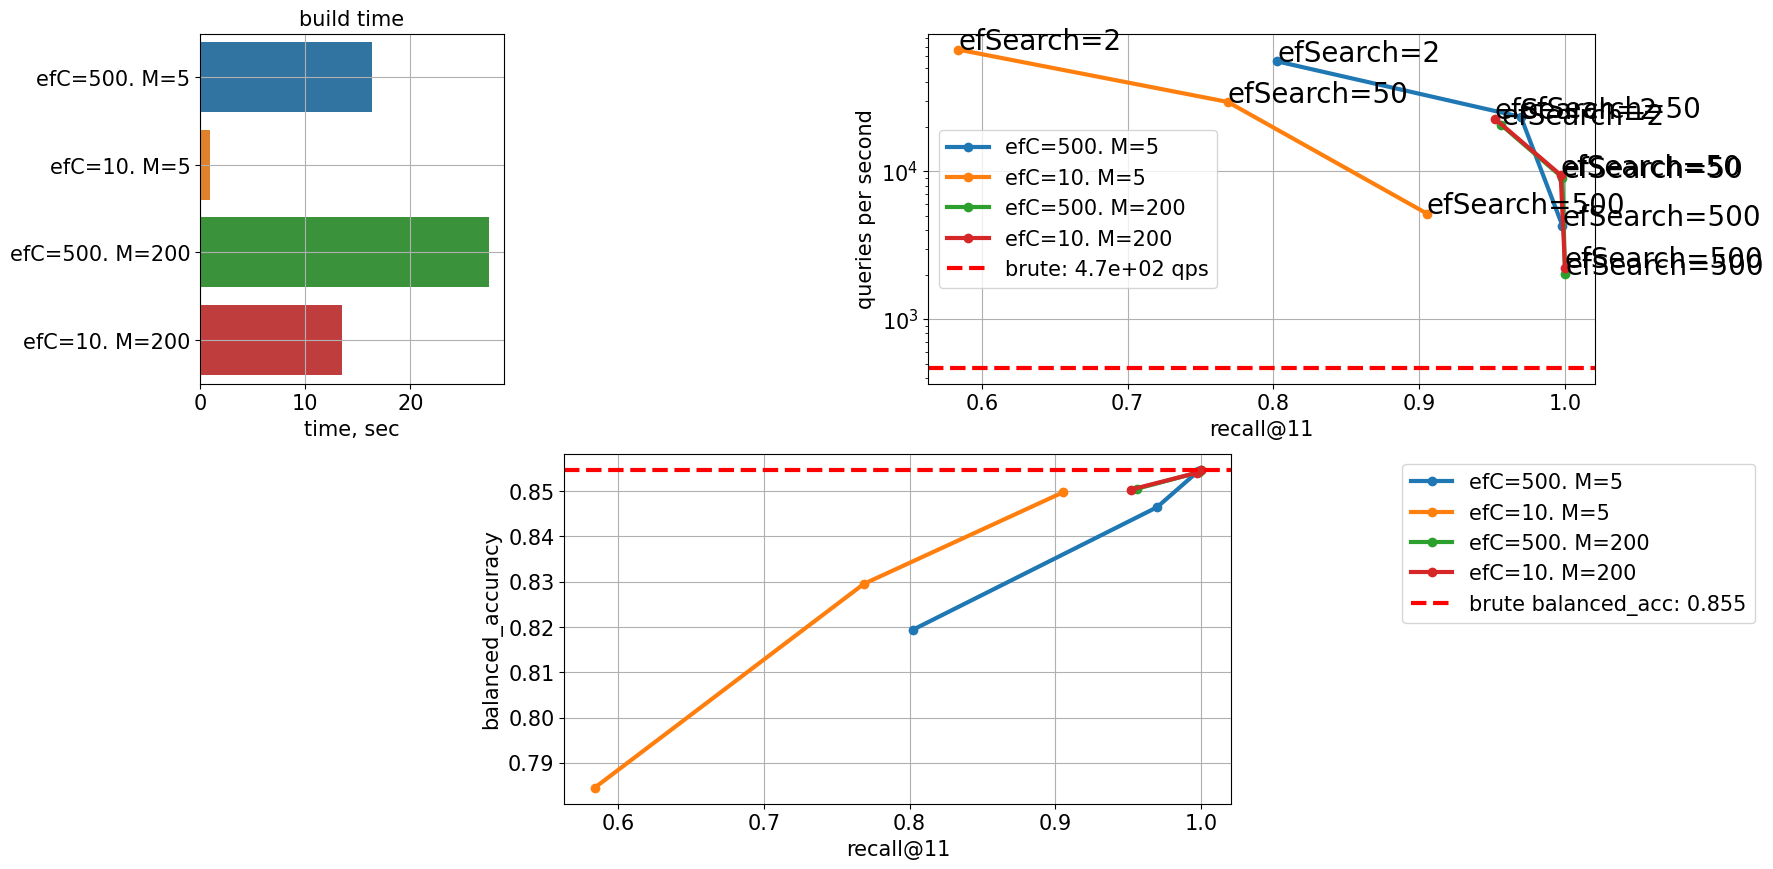

In [15]:
hnsw_plotter.show()

Сравнения с остальными

In [16]:
%time plotter.prepare_hnsw(X_val, y_val, name='HNSW', ef_construction=200, M=50, ef_search_list=[10, 50, 100, 500, 1000, 2000])


HNSW. ef_construction=200, M=50 | build_time: 11.923 sec
HNSW. ef_search=10 | search_time: 0.363 sec
HNSW. ef_search=50 | search_time: 0.881 sec
HNSW. ef_search=100 | search_time: 1.384 sec
HNSW. ef_search=500 | search_time: 4.031 sec
HNSW. ef_search=1000 | search_time: 6.516 sec
HNSW. ef_search=2000 | search_time: 10.58 sec
CPU times: total: 2min 22s
Wall time: 37.1 s


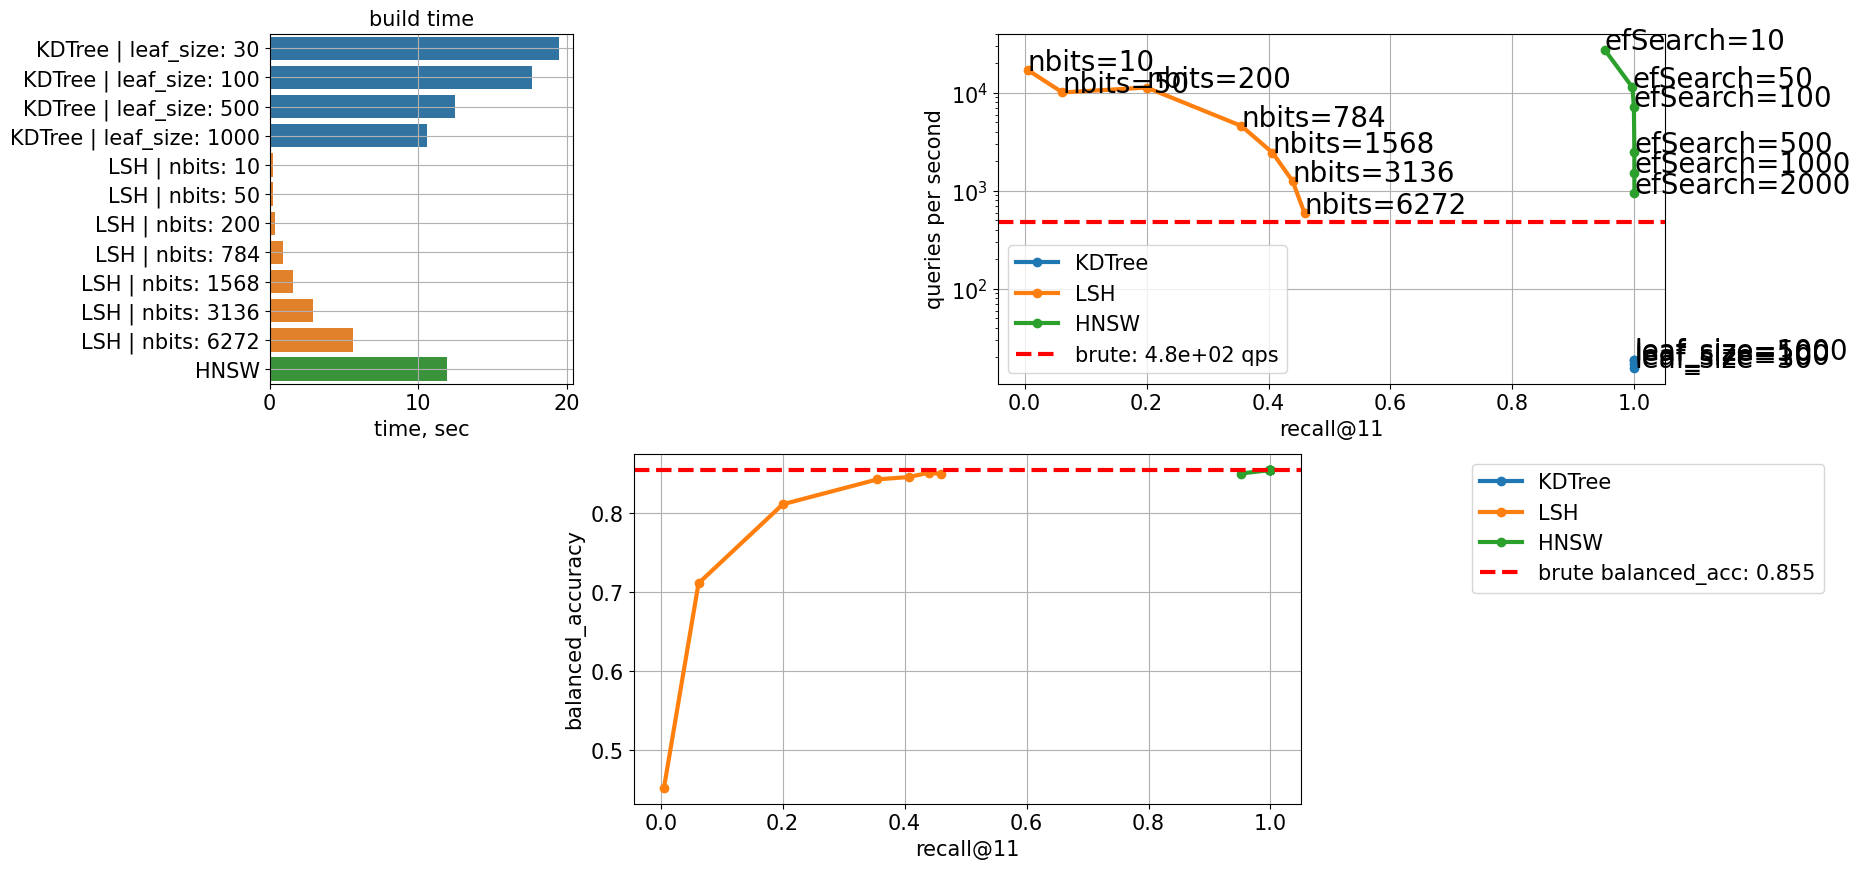

In [17]:
plotter.show()

Проблемы:
1) хранение всей выборки + хранение графа
2) на практике для hnswlib: только l2, cosine, inner-product функции близости

Плюсы:
1) адекватная скорость построение индекса
2) в теории: любые функции близости
3) отличная точность

## Продолжение следует...